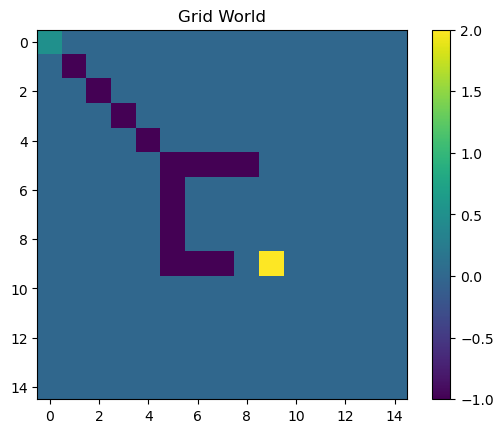

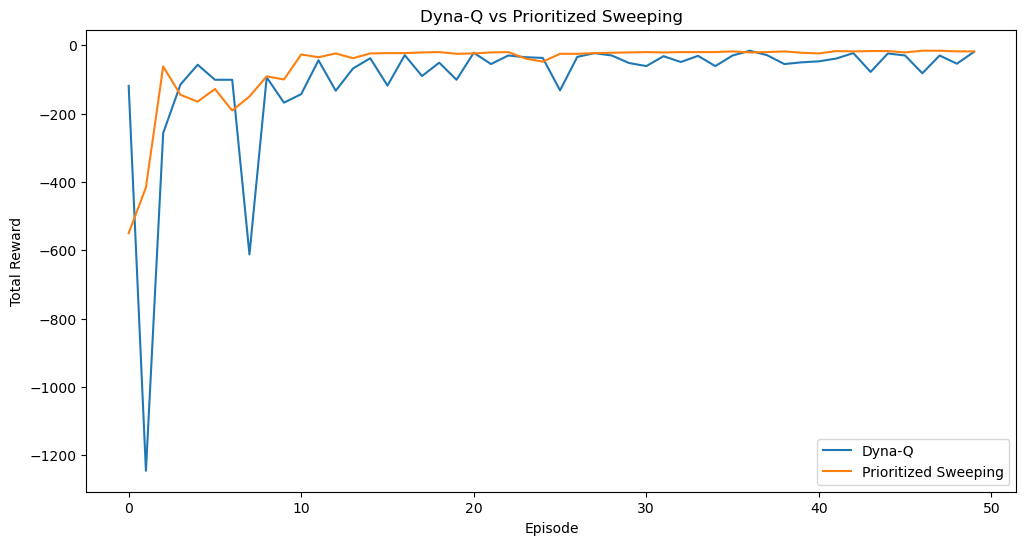

In [1]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

# 定义环境
class GridWorld:
    def __init__(self, width, height, goal, obstacles):
        self.width = width
        self.height = height
        self.goal = goal  # 目标位置 (x, y)
        self.obstacles = obstacles  # 障碍物列表 [(x1, y1), (x2, y2), ...]
        self.actions = ['up', 'down', 'left', 'right']  # 可能的动作

    def reset(self):
        # 固定初始位置为 (0, 0)
        self.agent_pos = (0, 0)
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        if action == 'up':
            y = max(y - 1, 0)
        elif action == 'down':
            y = min(y + 1, self.height - 1)
        elif action == 'left':
            x = max(x - 1, 0)
        elif action == 'right':
            x = min(x + 1, self.width - 1)

        # 检查新位置是否是障碍物
        if (x, y) in self.obstacles:
            x, y = self.agent_pos  # 保持原位置

        self.agent_pos = (x, y)

        # 到达目标则奖励为 1，否则为 -1
        reward = 1 if (x, y) == self.goal else -1
        done = (x, y) == self.goal

        return (x, y), reward, done
    
    def visualize(self):
        # 创建网格
        grid = np.zeros((self.height, self.width))

        # 标记障碍物
        for obstacle in self.obstacles:
            grid[obstacle[1], obstacle[0]] = -1

        # 标记目标
        grid[self.goal[1], self.goal[0]] = 2

        # 标记初始位置
        grid[0, 0] = 0.5

        # 绘制网格
        plt.imshow(grid, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.title("Grid World")
        plt.show()


# Dyna-Q 算法
class DynaQ:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, n_planning=5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning

        # 初始化 Q 表
        self.Q = {}
        for x in range(env.width):
            for y in range(env.height):
                for action in env.actions:
                    self.Q[(x, y), action] = 0.0

        # 初始化模型
        self.model = {}

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.actions)
        else:
            q_values = [self.Q[state, a] for a in self.env.actions]
            max_q = max(q_values)
            candidates = [a for a in self.env.actions if self.Q[state, a] == max_q]
            return random.choice(candidates)

    def update(self, state, action, reward, next_state):
        max_q_next = max([self.Q[next_state, a] for a in self.env.actions])
        self.Q[state, action] += self.alpha * (reward + self.gamma * max_q_next - self.Q[state, action])

    def learn(self, num_episodes):
        episode_rewards = []

        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update(state, action, reward, next_state)
                self.model[state, action] = (next_state, reward)

                # 规划步骤
                for _ in range(self.n_planning):
                    model_state_action = random.choice(list(self.model.keys()))
                    model_next_state, model_reward = self.model[model_state_action]
                    self.update(model_state_action[0], model_state_action[1], model_reward, model_next_state)

                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            #print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        return episode_rewards


# Prioritized Sweeping 算法
class PrioritizedSweeping(DynaQ):
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, n_planning=5, theta=0.01):
        super().__init__(env, alpha, gamma, epsilon, n_planning)
        self.theta = theta  # 优先级阈值
        self.priority_queue = []  # 优先级队列

    def update(self, state, action, reward, next_state):
        # 计算 Bellman 误差
        max_q_next = max([self.Q[next_state, a] for a in self.env.actions])
        bellman_error = abs(reward + self.gamma * max_q_next - self.Q[state, action])
        if bellman_error > self.theta:
            heapq.heappush(self.priority_queue, (-bellman_error, (state, action)))  # 使用负值实现最大堆

        # 更新 Q 值
        self.Q[state, action] += self.alpha * (reward + self.gamma * max_q_next - self.Q[state, action])

    def learn(self, num_episodes):
        episode_rewards = []

        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update(state, action, reward, next_state)
                self.model[state, action] = (next_state, reward)

                # 规划步骤
                for _ in range(self.n_planning):
                    if not self.priority_queue:
                        break
                    _, (s, a) = heapq.heappop(self.priority_queue)
                    model_next_state, model_reward = self.model[(s, a)]
                    self.update(s, a, model_reward, model_next_state)

                    # 搜索并更新前驱状态
                    for pred_s, pred_a in self.model.keys():
                        pred_next_s, pred_r = self.model[(pred_s, pred_a)]
                        if pred_next_s == s:
                            self.update(pred_s, pred_a, pred_r, pred_next_s)

                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            #print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        return episode_rewards


# 测试 Dyna-Q 和 Prioritized Sweeping
if __name__ == "__main__":
    env = GridWorld(width=15, height=15, goal=(9, 9), 
                    obstacles=[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 5), (7, 5), (8, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 9), (7, 9)])
    env.visualize()
    
    # 运行 Dyna-Q
    dyna_q = DynaQ(env, n_planning=10)
    dyna_q_rewards = dyna_q.learn(num_episodes=50)

    # 运行 Prioritized Sweeping
    prioritized_sweeping = PrioritizedSweeping(env, n_planning=10, theta=0.01)
    prioritized_sweeping_rewards = prioritized_sweeping.learn(num_episodes=50)

    # 设置图像大小
    plt.figure(figsize=(12, 6))
    # 绘制对比曲线
    plt.plot(dyna_q_rewards, label="Dyna-Q")
    plt.plot(prioritized_sweeping_rewards, label="Prioritized Sweeping")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Dyna-Q vs Prioritized Sweeping")
    plt.legend()
    plt.show()